In [161]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture
from yellowbrick.cluster import KElbowVisualizer
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.cluster import KMeans
import lightgbm as lgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import plotly.graph_objs as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import shapiro
import warnings
from warnings import simplefilter

import plotly as py
import plotly.io as pio
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [162]:
df = pd.read_csv("./data_thuchanh.csv", encoding="latin-1", sep=';')

In [163]:
print((2151260823 % 16 )  + 1)
print((2151260823 % 16 )  + 4)
print((2151260823 % 16 )  + 16)

8
11
23


In [164]:
feats= ['8', '11', '23']

In [165]:
df[feats].info()
data = df[feats]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   8       365 non-null    float64
 1   11      365 non-null    float64
 2   23      365 non-null    float64
dtypes: float64(3)
memory usage: 8.7 KB


In [166]:
data.head(5)

,8,11,23
0,964.4,964.4,945.5
1,1019.7,1019.7,1019.7
2,988.4,988.4,988.4
3,1002.0,1010.8,1009.2
4,1061.5,1061.5,1061.5


# EDA

In [167]:
summary = data.describe()
print(summary)


                 8           11           23
count   365.000000   365.000000   365.000000
mean   1040.228219  1040.311233  1037.076438
std     105.147104   105.147265   104.641477
min     885.700000   885.700000   782.800000
25%     988.400000   988.400000   988.400000
50%    1022.600000  1022.600000  1022.600000
75%    1061.500000  1061.500000  1061.500000
max    1565.500000  1565.500000  1565.500000


## Kiem tra du lieu thieu

In [168]:
missing_values = data.isnull().sum()
print(missing_values)


8     0
11    0
23    0
dtype: int64


## Bieu do phan phoi du lieu cua 3 cot

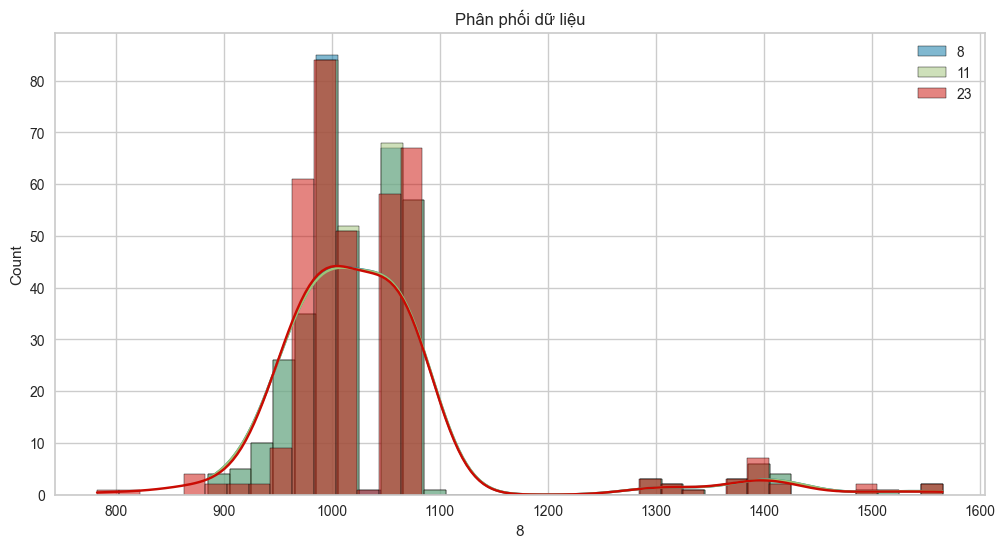

In [169]:
plt.figure(figsize=(12, 6))
for column in data.columns:
    sns.histplot(data[column], kde=True, label=column)
plt.legend()
plt.title('Phân phối dữ liệu')
plt.show()

## Kiem tra ngoai le

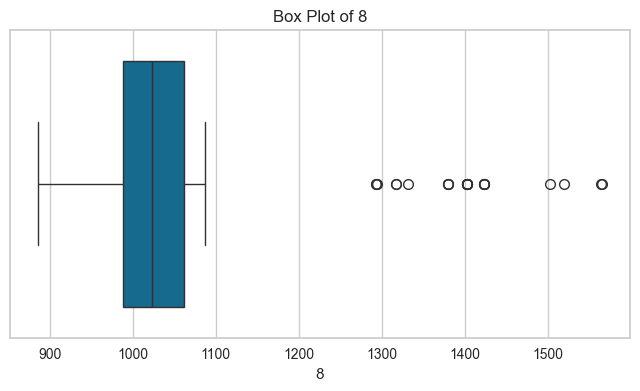

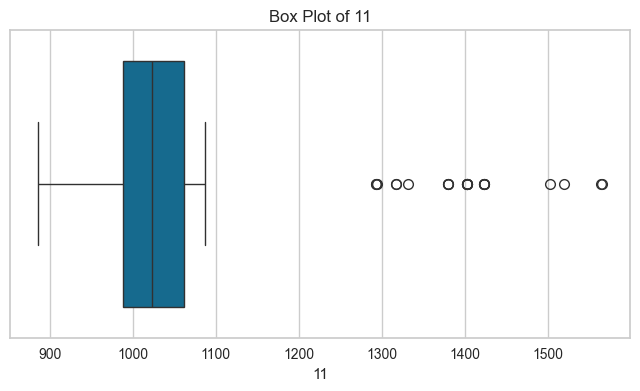

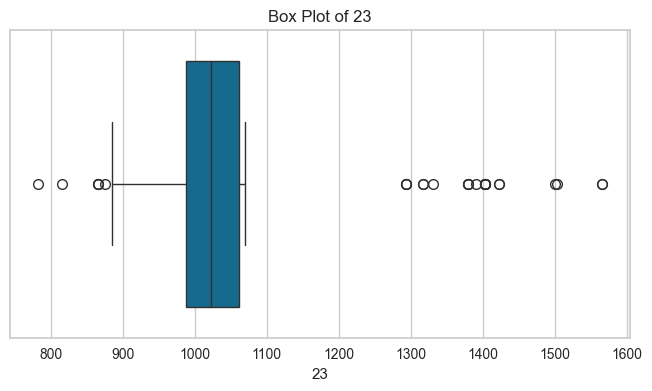

In [170]:
for column in feats:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot of {column}')
    plt.xlabel(column)
    plt.show()


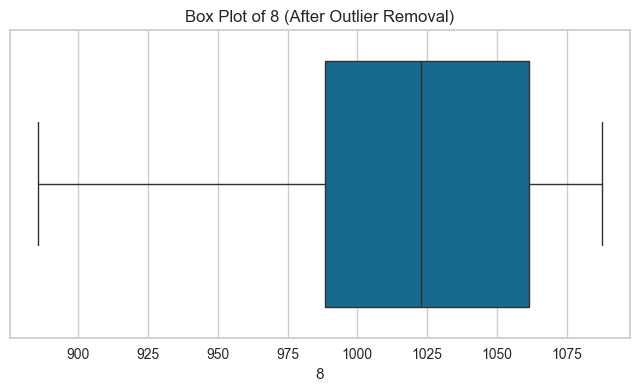

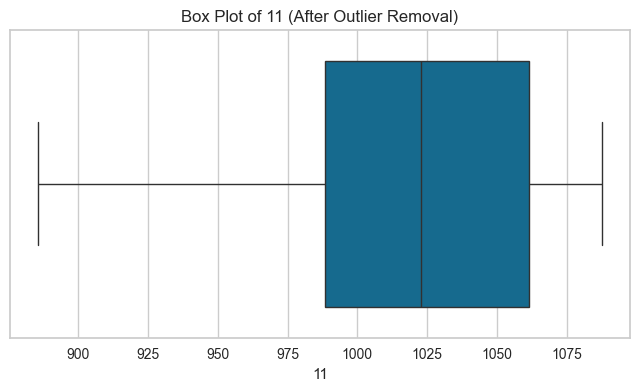

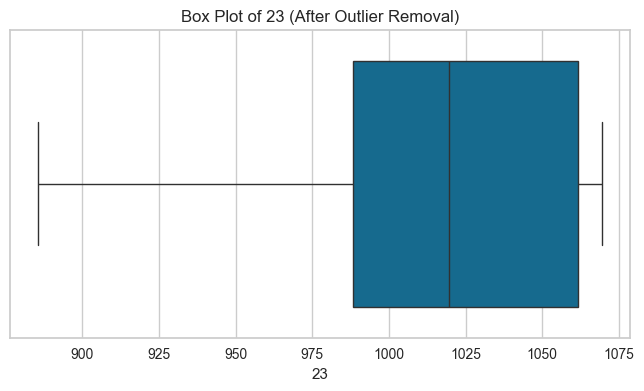

In [171]:
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1


data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]

for column in feats:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[column])
    plt.title(f'Box Plot of {column} (After Outlier Removal)')
    plt.xlabel(column)
    plt.show()

## Ve lai bieu do phan phoi sau khi loai bo ngoai le

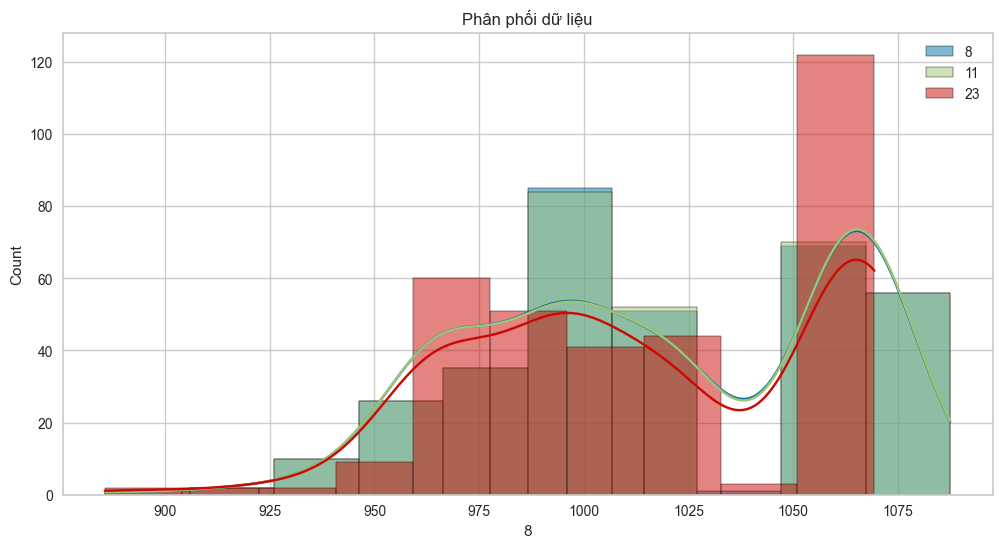

In [172]:
plt.figure(figsize=(12, 6))
for column in data.columns:
    sns.histplot(data[column], kde=True, label=column)
plt.legend()
plt.title('Phân phối dữ liệu')
plt.show()

## Bieu do tuong quan

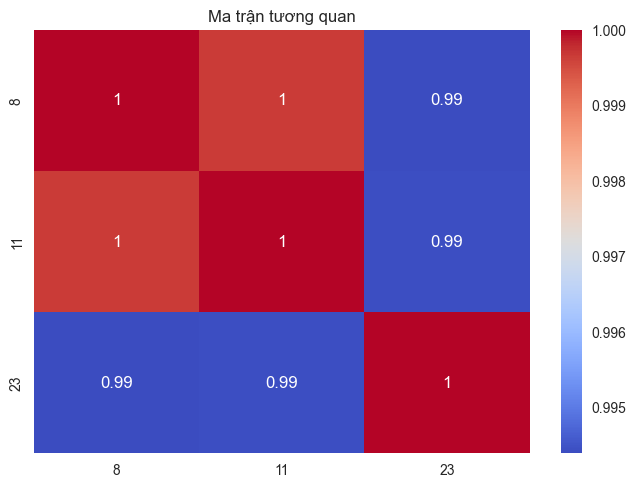

In [173]:
correlation = data.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Ma trận tương quan')
plt.show()

# Bộ lọc Kalman sử dụng thư viện 

    filtered_1   filtered_2   filtered_3
0   975.876134   976.063452   961.590629
1   998.828401   999.390357   993.771888
2  1000.909068  1002.407620  1000.025034
3  1015.498804  1019.432502  1017.903213
4  1043.587343  1045.089887  1044.484607


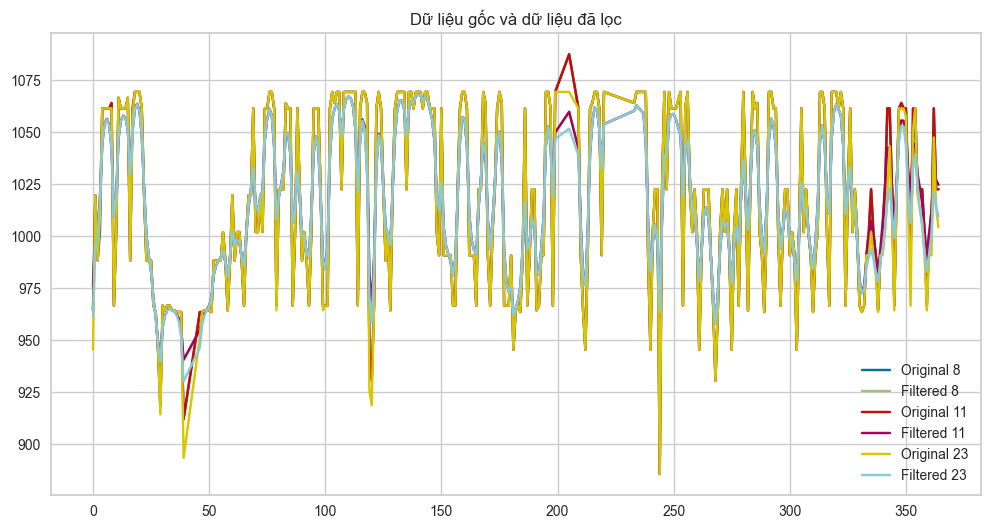

In [174]:
measurements = data.values
kf = KalmanFilter(initial_state_mean=measurements[0], n_dim_obs=measurements.shape[1])
state_means, state_covariances = kf.smooth(measurements)

filtered_data = pd.DataFrame(state_means, columns=[f'filtered_{i}' for i in range(1, measurements.shape[1] + 1)])
print(filtered_data.head())

plt.figure(figsize=(12, 6))
for i, column in enumerate(data.columns):
    plt.plot(data.index, data[column], label=f'Original {column}')
    plt.plot(data.index, filtered_data[f'filtered_{i+1}'], label=f'Filtered {column}')
plt.legend()
plt.title('Dữ liệu gốc và dữ liệu đã lọc')
plt.show()


# Mô hình 1 - XGBoost

Mean Squared Error: 23.02009070401383
R2 Score: 0.9686249104586199


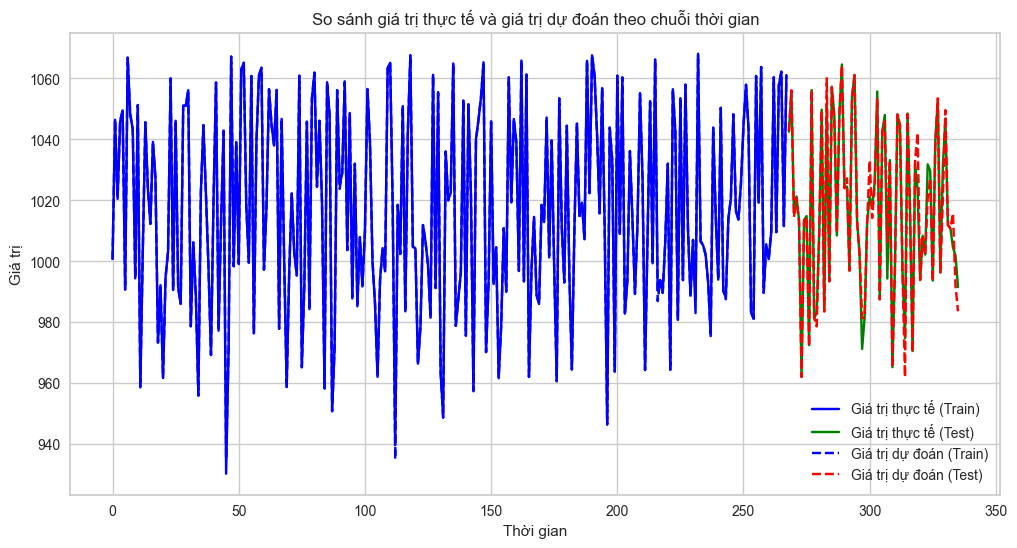

In [175]:

X = filtered_data[['filtered_1', 'filtered_2']]
y = filtered_data['filtered_3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

y_train_pred = model.predict(X_train)
full_y_true = np.concatenate([y_train, y_test])
full_y_pred = np.concatenate([y_train_pred, y_pred])

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_train)), y_train, label='Giá trị thực tế (Train)', color='blue')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Giá trị thực tế (Test)', color='green')
plt.plot(np.arange(len(y_train)), y_train_pred, label='Giá trị dự đoán (Train)', color='blue', linestyle='--')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, label='Giá trị dự đoán (Test)', color='red', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị thực tế và giá trị dự đoán theo chuỗi thời gian')
plt.legend()
plt.show()


# Mô hình 2 - RandomForestRegressor

Mean Squared Error: 12.34949532361765
R2 Score: 0.9831683321081875


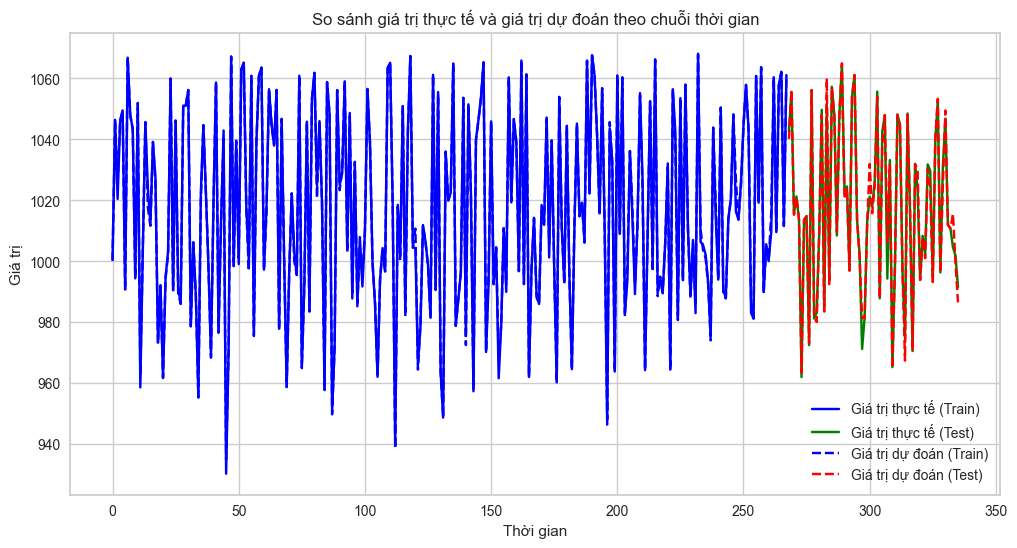

In [176]:

X = filtered_data[['filtered_1', 'filtered_2']]
y = filtered_data['filtered_3']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')

y_train_pred = model.predict(X_train)
full_y_true = np.concatenate([y_train, y_test])
full_y_pred = np.concatenate([y_train_pred, y_pred])

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(y_train)), y_train, label='Giá trị thực tế (Train)', color='blue')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, label='Giá trị thực tế (Test)', color='green')
plt.plot(np.arange(len(y_train)), y_train_pred, label='Giá trị dự đoán (Train)', color='blue', linestyle='--')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, label='Giá trị dự đoán (Test)', color='red', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị thực tế và giá trị dự đoán theo chuỗi thời gian')
plt.legend()
plt.show()


# Mô hình 3 - Sarima kết hợp LinearRegression

In [177]:
def check_stationarity(data, column):
    result = adfuller(data[column])
    print(f'ADF Statistic for {column}: {result[0]}')
    print(f'p-value for {column}: {result[1]}')
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

for column in filtered_data.columns:
    check_stationarity(filtered_data, column)



ADF Statistic for filtered_1: -4.244739410406611
p-value for filtered_1: 0.0005529608306678656
Critical Values:
   1%, -3.4508226600665037
Critical Values:
   5%, -2.870558121868621
Critical Values:
   10%, -2.571574731684734
ADF Statistic for filtered_2: -4.245335944173073
p-value for filtered_2: 0.0005516632599588685
Critical Values:
   1%, -3.4508226600665037
Critical Values:
   5%, -2.870558121868621
Critical Values:
   10%, -2.571574731684734
ADF Statistic for filtered_3: -4.306377965025908
p-value for filtered_3: 0.000433050113046948
Critical Values:
   1%, -3.4508226600665037
Critical Values:
   5%, -2.870558121868621
Critical Values:
   10%, -2.571574731684734


C:\Users\khenh\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\khenh\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided and will be ignored when e.g. forecasting.

C:\Users\khenh\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Users\khenh\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



Mean Squared Error: 54.14011829655507
R2 Score: 0.7228547975978554


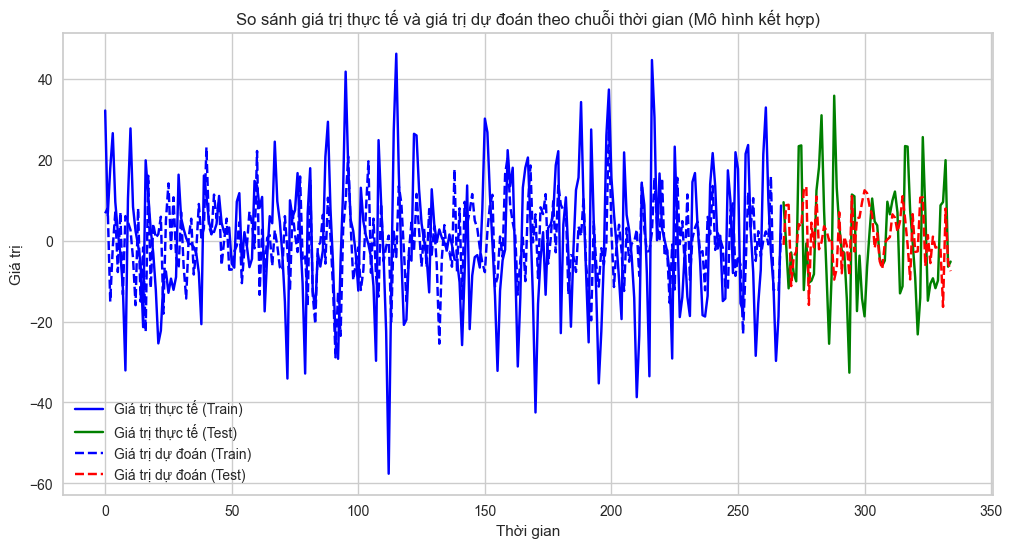

In [179]:

X = filtered_data_diff[['filtered_1', 'filtered_2']]
y = filtered_data_diff['filtered_3']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

sarima_model = SARIMAX(train, order=(1, 0, 3), seasonal_order=(1, 0, 3, 12))
sarima_model_fit = sarima_model.fit(disp=False)

y_train_pred_sarima = sarima_model_fit.predict(start=0, end=len(train)-1)
y_test_pred_sarima = sarima_model_fit.predict(start=len(train), end=len(train)+len(test)-1)

y_train_pred_combined = (y_train_pred_lr + y_train_pred_sarima[:len(y_train_pred_lr)]) / 2
y_test_pred_combined = (y_test_pred_lr + y_test_pred_sarima) / 2

mse_combined = mean_squared_error(y_test, y_test_pred_combined)
r2_combined = r2_score(y_test, y_test_pred_combined)
print(f'Mean Squared Error: {mse_combined}')
print(f'R2 Score: {r2_combined}')

plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(train)), train, label='Giá trị thực tế (Train)', color='blue')
plt.plot(np.arange(len(train), len(train) + len(test)), test, label='Giá trị thực tế (Test)', color='green')
plt.plot(np.arange(len(train)), y_train_pred_combined, label='Giá trị dự đoán (Train)', color='blue', linestyle='--')
plt.plot(np.arange(len(train), len(train) + len(test)), y_test_pred_combined, label='Giá trị dự đoán (Test)', color='red', linestyle='--')
plt.xlabel('Thời gian')
plt.ylabel('Giá trị')
plt.title('So sánh giá trị thực tế và giá trị dự đoán theo chuỗi thời gian (Mô hình kết hợp)')
plt.legend()
plt.show()